# <font color=blue>Call 911! </font>
*In this post, we'll explore an alternative universe, in which the city of Seattle receives 911 calls for only four reasons: an accident involving beavers, a seal attack, a Marshawn Lynch sighting, or a hot latte spills in someone's lap.*

We're given a data set consisting of the 911 call logs. Our task is to learn from this data to predict the reason for any 911 call. We'll use the methods of data science to examine this data set and build a model to identify some of its underlying patterns. We'll test our model by making predictions and evaluating its performance. <br><br>Along the way, you'll encounter and absorb key concepts that are at the heart of the data science process. Ready? Come along, then. As Chris Cuomo would say: "Let's get after it!"


## <font color=blue>Prelude: eine kleine exploratory data analysis</font>
We shall first set up the environment with the libraries we will need, load the data into a `pandas` dataframe, and preprocess the data. Next, we'll examine the layout of the dataframe and obtain some basic information about the data, such as the length, names, and data types of the columns, and look for nulls. The data set is comprised of the geospatial coordinates (latitude and longitude) of the call, and the call type. We find that there is no missing data, which is nice!

In [1]:
# set up environment, and import required modules
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import IPython.core.display
from IPython.display import display
from sklearn.model_selection import train_test_split
from pandas import ExcelWriter
from pandas import ExcelFile
from mpl_toolkits.basemap import Basemap
from matplotlib.ticker import FormatStrFormatter
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Note: installed basemap with 
#    conda install -c conda-forge basemap
#    conda install -c conda-forge basemap-data-hires
#    conda install geos
#    conda install proj4
# https://matplotlib.org/basemap/users/installing.html
#    conda install -c anaconda pillow 

# load the data
data_file = 'seattle_911_calls.xlsx'#'rev data for test.xlsx'
df = pd.read_excel(data_file)

# inspect data frame
display(df.head())

# information: length of the data frame, the data types of the columns, and check for nulls
print('\nDescription of data frame:')
print(df.info())

# unique values of 911 call type
print('\nThese are the unique 911 call types:')
print(df.Type.unique())

# preprocess the data:

# define a color mapping for 911 call types
color_dict = {'Seal Attack':'r','Beaver Accident':'b','Latte Spills':'m','Marshawn Lynch Sighting':'k'}
df['color'] = df['Type'].map(color_dict)

# convert longitude and latitude to lists   
lats = df['Latitude'].tolist()
lons = df['Longitude'].tolist()

# extract the 'report longitude and latitude' column and convert to lists   
report_locations = [re.findall('\d*\.?\d+',s) for s in df['Report Location']]
report_lats = [float(str[0]) for str in report_locations]
# reverse the sign of report_lons; they are all positive, which is an error
report_lons = [-float(str[1]) for str in report_locations]



,Type,Latitude,Longitude,Report Location
0,Beaver Accident,47.6992,-122.2167,"(47.6291923608656, -122.186728398282)"
1,Beaver Accident,47.6977,-122.2164,"(47.5576821104334, -122.156421437319)"
2,Beaver Accident,47.6967,-122.2131,"(47.6167258135906, -122.173139389518)"
3,Beaver Accident,47.6971,-122.2178,"(47.5370517340417, -122.197755316941)"
4,Beaver Accident,47.6925,-122.2127,"(47.6124577512516, -122.14272010056)"



Description of data frame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1514 entries, 0 to 1513
Data columns (total 4 columns):
Type               1514 non-null object
Latitude           1514 non-null float64
Longitude          1514 non-null float64
Report Location    1514 non-null object
dtypes: float64(2), object(2)
memory usage: 47.4+ KB
None

These are the unique 911 call types:
['Beaver Accident' 'Seal Attack' 'Latte Spills' 'Marshawn Lynch Sighting']


### What's the most common reason for calling 911?

In the cell below, we count the examples of each call type, finding that the most common reason for calling 911 is **Beaver Accident**. Next is **Latte Spills**, followed by **Marshawn Lynch Sighting** and **Seal Attack**.

In [2]:
# Grouping by call type and counting, we see that the most common reason
#     for calling 911 is "Beaver Accident.
df.groupby('Type').count()['color']


Type
Beaver Accident            508
Latte Spills               416
Marshawn Lynch Sighting    324
Seal Attack                266
Name: color, dtype: int64

### The distribution of call types is best shown in a histogram


Text(0.5,1,'Distribution of 911 call types')

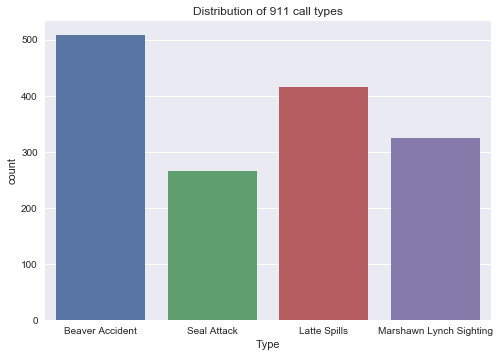

In [3]:
# plot a histogram of call types
sns.set(style="darkgrid")
ax = sns.countplot(x="Type", data=df)
plt.title('Distribution of 911 call types')

## <font color=blue>A bird's eye view of Seattle 911 calls</font>

### Let's make a map displaying the 911 call data

In this plot, we overlay all the call locations in our data set as solid dots onto a map of the Seattle area obtained from the `arcGIS` web-based map service. The dots are color-coded to indicate the type of call. The map shows that generally, calls of different categories tend to lie in well-defined regions. This bodes well for applying machine learning to the classification problem.

http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=-122.4699401,47.5002,-122.1401,47.732&bboxSR=4269&imageSR=4269&size=3500,2459&dpi=500&format=png32&f=image


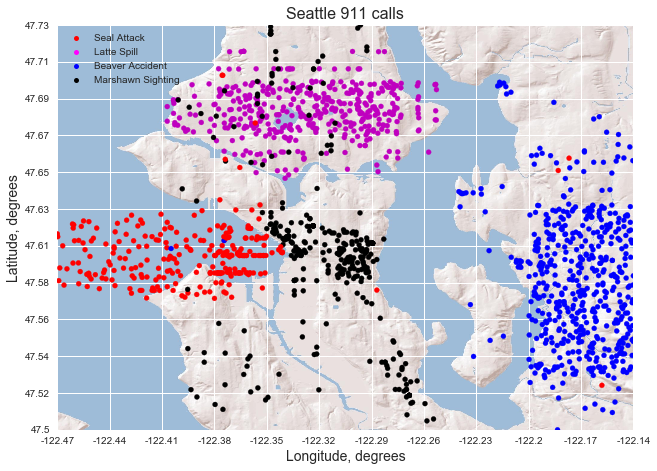

In [4]:
# plot the 911 calls overlaid on a map of Seattle

# set up the bounding box for the map
lat_min = np.min(lats)
lat_max = np.max(lats)
lon_min = np.min(lons)
lon_max = np.max(lons)
bbox = [lat_min, lat_max, lon_min, lon_max]

# make the figure and set its title and label axes
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0., 0., 1., 1., ]) 
ax.set_title('Seattle 911 calls', fontsize=16)
ax.set_xlabel('Longitude, degrees', fontsize=14)
ax.set_ylabel('Latitude, degrees', fontsize=14)

# define the region, projection, corners, and the resolution of the map
# EPSG Number of America is 4269
map = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=0,resolution='i',epsg=4269)

# choose the arcgis map service, and create a geospatial map of Seattle
# examples of different maps are at
# http://kbkb-wx-python.blogspot.com/2016/04/python-basemap-background-image-from.html, and
# http://server.arcgisonline.com/arcgis/rest/services
map.arcgisimage(service='World_Shaded_Relief',xpixels = 3500,dpi=500,verbose= True)

# overlay the lat and lon in the 911 call locations, with the markers coded by 911 call type
x, y = map(lons, lats)  # transform coordinates
x_report, y_report = map(report_lons, report_lats)  # transform coordinates
map.scatter(x, y, s=100, marker='.', color=df['color'])
# also overlay the lat and lon from the 'report locations' column
#     these are strange
#     the Marshawn sitings almost all coincide with the lat and lon
#     seal attacks have two clusters, one of which is outside the lat and lon 
#         the seal attacks
#     latte spills and beaver accidents seem to be random distributions of points
#         in boxes to which noise was added to give the points in the Latitude 
#         and Longitude columns
#     as the assessment questions don't concern the 'report locations',
#         we won't consider them further
# map.scatter(x_report, y_report, s=50, marker='o', color=df['color'],facecolors='none', edgecolors=df['color'])

# set x-axis ticks and tick labels 
x_ticks = np.linspace(lon_min, lon_max,12)
ax.set_xticks(x_ticks)
x_ticklabels = [str(round(tick,2)) for tick in x_ticks]
ax.set_xticklabels(x_ticklabels, fontsize=10 )

# set y-axis ticks and tick labels 
y_ticks = np.linspace(lat_min, lat_max,12)
ax.set_yticks(y_ticks)
y_ticklabels = [str(round(tick,2)) for tick in y_ticks]
ax.set_yticklabels(y_ticklabels, fontsize=10 )

# add legend
r_true = mlines.Line2D([], [], color='red', marker='.', linestyle='None',
                          markersize=10, label='Seal Attack')
m_true = mlines.Line2D([], [], color='magenta', marker='.', linestyle='None',
                          markersize=10, label='Latte Spill')
b_true = mlines.Line2D([], [], color='blue', marker='.', linestyle='None',
                          markersize=10, label='Beaver Accident')
k_true = mlines.Line2D([], [], color='black', marker='.', linestyle='None',
                          markersize=10, label='Marshawn Sighting')
ax.legend(handles=[r_true,m_true,b_true,k_true],loc='upper left', fontsize=10)


# save the figure in png format
plt.savefig('seattle.png', format='png', dpi=500)

### Are there mislabeled data points?
From the map we can identify a small number of points that are likely mislabeled. Seal attacks should be in and near the ocean, so the few that are deep inland may be mislabeled. Beavers live inland near rivers, so the two Beaver Attacks that are out in the ocean at the left may be mislabeled. Latte Spills can occur on land or sea, and Marshawn Lynch Sightings do not occupy a well-defined region, so we have no way to judge whether any of these are mislabeled.

## <font color=blue>Which machine learning algorithm should we choose?</font>

Our goal is to predict the reason for any 911 call if we know only its latitude and longitude coordinates. The map we made previously shows that the call types tend to lie in distinct, mutually exclusive geographic regions. We can use machine learning methods to build a classifier that 'learns' the regions associated with each of the four call types based on latitude and longitude, and assigns a 911 call to the most probable call type. <br><br>Clustering methods such as **k-Means** and **k Nearest Neighbors** should achieve good results. However, from the map, we also notice that the boundaries of each region are generally nearly *parallel* to lines of longitude and latitude. For this reason, decision tree methods such as the **Random forest** and **Gradient boosting machines** should be ideal for this problem, since they build trees that partition space into collections of box-like latitude and longitude ranges. <br><br>Having settled on decision tree methods as the most suitable for our problem, we choose to build our classifier with the Random Forest algorithm. The Random Forest is based on an ensemble of decision trees (unsurprisingly called a forest), with each decision tree based on a different random sample of the data. The Random Forest assigns each call to the **majority class**, i.e., the class that received the most votes among the decision trees. <br><br>The Random Forest algorithm has a number of advantageous features. It is simple to tune and has a good implementation in the `scikit-learn` library. It is robust and resistant to overfitting, thanks to the use of 'crowd-sourcing' over ensemble of decision trees. Finally, it offers 'built-in cross-validation' when the **bootstrap sampling** option is chosen. This will be further discussed below.


## <font color=blue>Does our algorithm depend on Euclidean distance?</font>

With the Random Forest (or any decision tree method), only the *relative spatial ordering* of the points matters, so we need only the position coordinates and there is no need for a distance measure. On the other hand, if we were to use a clustering method such as k-Means or k Nearest Neighbors, we *would* need to compute distances between call locations.  <br><br>**The next three sections are completely optional.** In them, we'll discuss how to compute distances from latitudes and longitudes. Feel free to skip them, since our treatment of the problem doesn't involve distances. On the other hand, if you think you might want to apply clustering methods to similar problems in the future (and you don't mind a bit of math), read on!

### How to compute distances using latitude and longitude (optional)
Latitude and longitude are not a Euclidean distance measure, but at the scale of cities they can be effectively treated as Euclidean, provided we apply the **cosine correction factor** to the longitude difference, as we'll discuss below. The **Euclidean distance** between two points on the surface of a sphere is the distance along the straight line connecting them. The distance between two points on the surface of the Earth is the shortest path between them on the Earth's surface. A little thought shows that this path is an *arc* because of Earth's curvature. The Euclidean distance between two points on a circle is the length of the *chord* connecting them, while the **arc distance** is the length of the *arc* connecting them.  The arc distance is the correct distance metric for the surface of a sphere, and is always longer than the Euclidean distance. <br><br>Indeed, let the two points be the North and South poles. The Euclidean distance between them is $2R_{Earth}$, while the arc distance between them on the surface of the Earth is $\pi R_{Earth}$, which is greater by a factor of $\approx1.5$!<br><br> Mathematically, the arc distance between points on the Earth is $D_{arc}=R_{Earth}\theta$, where $\theta$ is the angle subtended by the two points at the Earth's center, and $R_{Earth}$ is the Earth's radius. The Euclidean distance is the chord length $D_{Euclidean} = 2R_{Earth}sin(\frac{\theta}{2})$. At the scale of a city, $\theta \ll \pi$. The small angle formula $sin\theta \approx \theta$ applies, so that $D_{Euclidean} = 2R_{Earth}sin(\frac{\theta}{2}) \approx 2R_{Earth}\frac{\theta}{2} =  
R_{Earth} \theta = D_{arc}$. **Therefore, the Euclidean distance between points in a city is an excellent approximation to the arc distance.** <br><br>In the following sections we will see how to compute the arc distance and the Euclidean distance between two points directly from their latitudes and longitudes.

### Euclidean distance (optional)
Let two points on the Earth's surface be specified by $(\lambda_{1},\phi_{1})$ and $(\lambda_{2},\phi_{2})$, where $\lambda$ and $\phi$ represent longitude and latitude in radians, respectively. Let us assume that the points are within a city so that they are close together relative to the size of the Earth. The latitude difference in radians of true arc is  $\Delta\phi = \phi_{2}$ - $\phi_{1}$. The longitude difference is $\Delta\lambda = \lambda_{2} - \lambda_{1}$, but to compute a Euclidean distance, we must by scale this by $cos(\phi)$ to convert to radians of true arc. The cosine factor accounts for the 'squeezing together' of longitude lines at higher latitudes, and its value at Seattle's latitude is $\sim 0.68$, which is quite significant! So the longitude difference in radians of true arc is $\Delta\lambda^{'} \approx (\lambda_{2} - \lambda_{1})cos(\phi)$ where $\phi = (\phi_{1}+\phi_{2})/2$. The angular distance between the points, projected onto a tangent plane at the Earth's surface, is $\theta_{12} \approx \sqrt{(\Delta\phi)^{2}+(\Delta\lambda^{'})^{2}}$. The Euclidean distance is obtained by multiplying the angular distance by the radius of the Earth: $D_{Euclidean} \approx R_{Earth}\theta_{12} = R_{Earth}\sqrt{(\Delta\phi)^{2}+(\Delta\lambda^{'})^{2}}$.   

### Arc distance (optional)
The **angular distance** $\theta_{12}$ between two points on the Earth's surface can be computed exactly via the  the dot product of the vectors $\vec{R_{1}}$ and $\vec{R_{2}}$ representing the points. $cos(\theta) = \vec{R_{1}} \cdot \vec{R_{2}}$, so that the angular distance is $\theta_{12} = cos^{-1}(\vec{R_{1}} \cdot \vec{R_{2}})$.
To calculate the dot product in terms of the longitudes and latitudes, we set up a Cartesian coordinate system with the XY plane coinciding with the plane of the equator, such that the X-axis extends from Earth's center through the point on the surface of the Earth at zero longitude, and the Z-axis extends from Earth's center through the geographic North pole.
The Cartesian vectors representing the points are $\vec{R_{1}}=[x_{1},y_{1},z_{1}] = R_{Earth}[cos(\phi_{1})cos(\lambda_{1}),cos(\phi_{1})sin(\lambda_{1}),sin(\phi_{1})]$ and $\vec{R_{2}}=[x_{2},y_{2},z_{2}] = R_{Earth}[cos(\phi_{2})cos(\lambda_{2}),cos(\phi_{2})sin(\lambda_{2}),sin(\phi_{2})]$, where  $[x_{1},y_{1},z_{1}]$ and $[x_{2},y_{2},z_{2}]$ are the Cartesian coordinates of the points, and $R_{Earth}$ is the radius of Earth. The **angular distance** in radians is $\theta_{12} = cos^{-1}(\vec{R_{1}} \cdot \vec{R_{2}}) = cos^{-1}( cos(\phi_{1})cos(\lambda_{1})cos(\phi_{2})cos(\lambda_{2})+cos(\phi_{1})sin(\lambda_{1})cos(\phi_{2})sin(\lambda_{2})+sin(\phi_{1})sin(\phi_{2}))$. The shortest distance on the Earth's surface between the points is the **arc distance**, the length of the arc on the surface of the Earth connecting the points, and is obtained by multiplying the **angular distance** by the radius of the Earth. The exact formula for the **arc distance** between two points on Earth's surface in terms of their latitudes and longitudes is therefore $D_{arc} = R_{earth} \theta_{12} = R_{earth} cos^{-1}( cos(\phi_{1})cos(\lambda_{1})cos(\phi_{2})cos(\lambda_{2})+cos(\phi_{1})sin(\lambda_{1})cos(\phi_{2})sin(\lambda_{2})+sin(\phi_{1})sin(\phi_{2}))$.


## <font color=blue>Building, training, and evaluating the Random Forest classifier</font>

We implemented the random forest classifier using the `scikit-learn` library. We used 70% of the data for training, reserving the remaining 30% as a test set to evaluate the performance of the classifier. We found that the model performs best when we do not 'prune' the trees, by setting `max_depth = None`. This is the only hyperparameter tuning that we did. Not pruning the trees carries a risk of **overfitting**, i.e. getting a model that is overly dependent on the data we used to train it, and thus does not generalize well to new data. So we will watch for overfitting, and revise our model to prune the trees by setting `max_depth` to a small value if necessary. <br><br> We choose the **bootstrap sampling** option so that we can use the predictions on the **out-of-bag** samples to estimate the **generalization accuracy**, i.e. the accuracy we should expect if we were to apply the classifier to new set of 911 call data. A **bootstrap sample** is a sample of N calls drawn **with replacement** from the N calls in the training set. Sampling with replacement means that each draw is made from the complete training data set. On average each bootstrap sample contains about 2/3 of the calls in the training set, because sometimes the same call will be drawn more than once. Each bootstrap sample is used to build a decision tree. For each such decision tree, the other 1/3 of the samples are not used -- these are called **out-of-bag** samples. Because the out-of-bag samples are not included in the tree, we can use the tree to predict their classes without the danger of overfitting. <br><br>**From the ensemble of out-of-bag predictions, we expect that our classifier should have a generalization accuracy of 96%.**

In [5]:
# Implement the random forest model
X = df[['Latitude','Longitude']].values
y = df['Type']

# assign data randomly into train and test data sets in a (70%, 30%) split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# build a random forest classifier 
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

# train the classifier using the training data set
clf.fit(X_train, y_train)

# use the 'out-of-bag' predictions to estimate the expected accuracy on the test data
print('The expected accuracy of the classifier on new data is '+str(round(clf.oob_score_,3)))


The expected accuracy of the classifier on new data is 0.96


### How well did our classifier perform?
Now comes the exciting part: it's time to evaluate how good our classifier is! To do this we'll use it to predict the categories for 911 calls in our **test set**, which have been held back hiddent from the modeling process, and then check  our predictions against the true categories. We'll also compute and plot the **confusion matrix**, which offers a quick view of classifier performance for each category. <br><br>From the first three rows of the confusion matrix, we see that for **Seal Attack**, **Beaver Accident**, and **Latte Spill** calls, our classifier is nearly perfect, only misclassifying one call in each of these categories. On other hand, **Marshawn Lynch sightings** are sometimes misclassified as **Latte Spills** or **Seal Attacks**, as can be seen from the last row of the confusion matrix.<br><br>**We achieved $\sim 97\%$ classification accuracy on the test data.**. This is an excellent result! It is close to the generalization accuracy predicted from the out-of-bag samples in the training data, and shows that we do not have an overfitting problem, even though we did not prune the decision trees. 

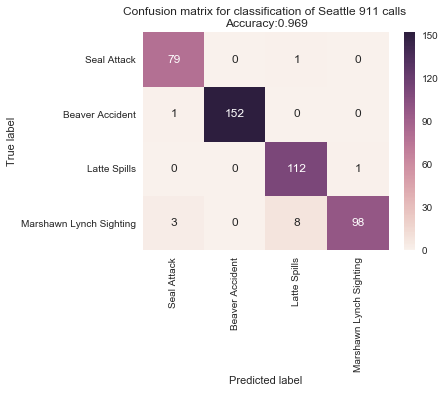

In [6]:
# predict labels for test set
y_pred_probs = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

# get the confusion matrix
labels = list(color_dict.keys())
confusion = confusion_matrix(y_test, y_pred, labels)

# transform to dataframe for sns plot
confusion_df = pd.DataFrame(confusion,
                     index = labels, 
                     columns = labels)

# plot the confusion matrix
plt.figure(figsize=(5.5,4))
sns.heatmap(confusion_df, annot=True,fmt='d')
plt.title('Confusion matrix for classification of Seattle 911 calls \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### How confident are we in the predictions for each class?
In addition to predicting the class for each call, the Random Forest computes **class probabilities**. In the next cell we show histograms of the class probabilities for each class. <br><br>For a given call, each of the `n_estimators=1000` decision trees in the ensemble (or 'forest') makes a class prediction. The call is then classified by polling the votes for each class over the ensemble of decision trees and choosing the **majority class**, the one with the most votes. <br><br>The **class probabilities** are the fraction of the votes received by each class. They give a measure how confident our model is in the prediction: a high probability for the majority class and low probabilities for the other classes is the hallmark of a high-confidence classification, whereas a weak vote for the majority class, and other classes that were almost as probable indicates low confidence in the classification. Examining at the distribution of class probabilities gives us insight into how robust are the classifications for each class. <br><br>In the plot below we can see that the class probability distributions are bimodal, having pronounced peaks near zero and one, meaning that most of the classifications are quite robust, having been decided by high vote majorities.

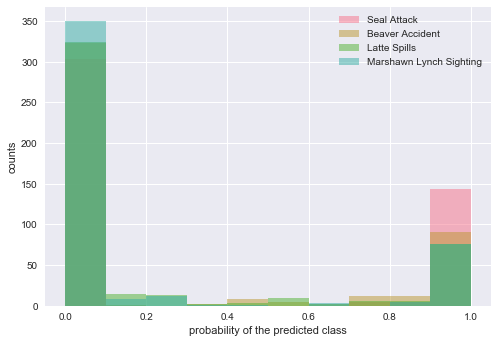

In [7]:
# plot the distribution of class probabilities
data = pd.DataFrame(y_pred_probs, columns=labels)

# set color palette
sns.set_palette("husl")
for col in labels:
    plt.hist(data[col] , alpha=0.5)
    #sns.distplot(data[col])
    #sns.kdeplot(data[col], shade=True)
plt.legend(labels)
plt.xlabel('probability of the predicted class')
plt.ylabel('counts')
plt.show()

### A bird's eye view of model performance on the test data
In the next plot, we first overlay the call locations of the test data with color coded dots indicating the type of call onto a map of the Seattle area, as in the plot we made for question (2A).  Then we encircle each dot with a ring indicating the **predicted class**, using the same color code. <br><br>In this plot, we can identify the regions in which the model performed best and also where its performance was weak. Misclassifications tend to occur near boundaries of the regions occupied by the various call classes, or in regions where more than one type of call occurs. For example, the call at latitude 47.63 and longitude near -122.35 -- on the boundary between the black and red regions -- appears as a black dot enclosed in a red circle, indicating that a Marshawn Lynch siting (black dot) was misclassified as a Seal Attack (red circle).

http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=-122.4699401,47.5002,-122.1401,47.732&bboxSR=4269&imageSR=4269&size=3500,2459&dpi=500&format=png32&f=image


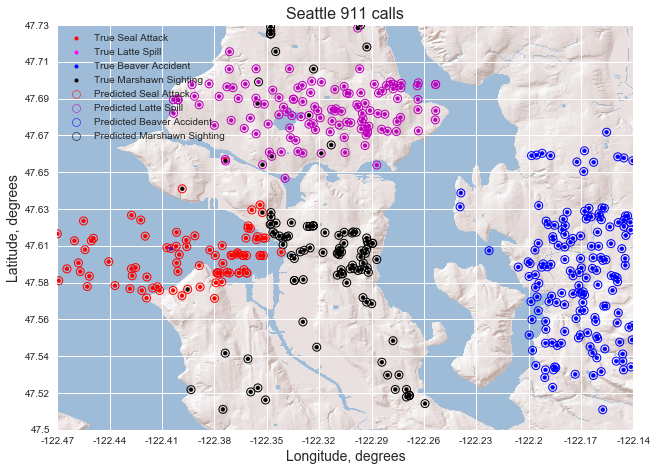

In [8]:
# list of colors corresponding to predicted labels
pred_labels = [label for label in y_pred]
pred_color = [color_dict[pred_labels[i]] for i in range(len(pred_labels))]

# list of colors corresponding to true labels
true_labels = [label for label in y_test]
true_color = [color_dict[true_labels[i]] for i in range(len(true_labels))]

# make the figure and set its title and label axes
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0., 0., 1., 1., ]) 
ax.set_title('Seattle 911 calls', fontsize=16)
ax.set_xlabel('Longitude, degrees', fontsize=14)
ax.set_ylabel('Latitude, degrees', fontsize=14)

# define the region, projection, corners, and the resolution of the map
# EPSG Number of America is 4269
map = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=0,resolution='i',epsg=4269)

# choose the arcgis map service, and create a geospatial map of Seattle
# examples of different maps are at
# http://kbkb-wx-python.blogspot.com/2016/04/python-basemap-background-image-from.html, 
# and http://server.arcgisonline.com/arcgis/rest/services
map.arcgisimage(service='World_Shaded_Relief',xpixels = 3500,dpi=500,verbose= True)

# overlay the lat and lon in the 911 call locations, 
# with the markers coded by true call type
lons_train = X_test[:,1]
lats_train = X_test[:,0]
x, y = map(lons_train, lats_train)
map.scatter(x, y, s=64, marker='.', color=true_color)

# overlay with markers colored by predicted call type
map.scatter(x, y, s=64, marker='o', color=pred_color,facecolors='none', 
            linewidths=1,edgecolors=pred_color)

# set x-axis ticks and tick labels 
x_ticks = np.linspace(lon_min, lon_max,12)
ax.set_xticks(x_ticks)
x_ticklabels = [str(round(tick,2)) for tick in x_ticks]
ax.set_xticklabels(x_ticklabels, fontsize=10 )

# set y-axis ticks and tick labels 
y_ticks = np.linspace(lat_min, lat_max,12)
ax.set_yticks(y_ticks)
y_ticklabels = [str(round(tick,2)) for tick in y_ticks]
ax.set_yticklabels(y_ticklabels, fontsize=10 )

# add legend
r_pred = mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                          markersize=8, label='Predicted Seal Attack',
                          markeredgewidth=.5,markerfacecolor='none', markeredgecolor='r')
m_pred = mlines.Line2D([], [], color='magenta', marker='o', linestyle='None',
                          markersize=8, label='Predicted Latte Spill',
                          markeredgewidth=.5,markerfacecolor='none', markeredgecolor='m')
b_pred = mlines.Line2D([], [], color='blue', marker='o', linestyle='None',
                          markersize=8, label='Predicted Beaver Accident',
                          markeredgewidth=.5,markerfacecolor='none', markeredgecolor='b')
k_pred = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=8, label='Predicted Marshawn Sighting',
                          markeredgewidth=.5,markerfacecolor='none', markeredgecolor='k')
r_true = mlines.Line2D([], [], color='red', marker='.', linestyle='None',
                          markersize=8, label='True Seal Attack')
m_true = mlines.Line2D([], [], color='magenta', marker='.', linestyle='None',
                          markersize=8, label='True Latte Spill')
b_true = mlines.Line2D([], [], color='blue', marker='.', linestyle='None',
                          markersize=8, label='True Beaver Accident')
k_true = mlines.Line2D([], [], color='black', marker='.', linestyle='None',
                          markersize=8, label='True Marshawn Sighting')
ax.legend(handles=[r_true,m_true,b_true,k_true,r_pred,m_pred,b_pred,k_pred],
          loc='upper left', fontsize=10)

# save the figure in png format
plt.savefig('seattle_pred.png', format='png', dpi=500)


### Number of correct categorizations

We find that the categories of 441 of the 455 calls in the test set were correctly predicted, for a classification accuracy of 96.9%.
Code to compute these statistics is shown below.

In [9]:
# compute the number of correct predictions and the accuracy on the test set
print(str(sum(y_pred==y_test))+' of the '+str(len(y_test))+' calls in the test set were correctly classified.')
print('The fraction of correctly classified calls in the test set is '+str(round(sum(y_pred==y_test)/len(y_test),3)))

441 of the 455 calls in the test set were correctly classified.
The fraction of correctly classified calls in the test set is 0.969


### Summary and insights gained

We've built and tested a classifier for the Seattle 911 calls, using the `scikit-learn` implementation of the Random Forest algorithm.
We've seen that as expected, the Random Forest algorithm is well-matched to our problem. Performance on the test data leaves little to be desired; we achieved high generalization accuracy ($\sim97\%$), with no evidence of overfitting.  Indeed, the classifier obtains nearly perfect accuracy on Seal Attacks, Beaver Accidents and Latte Spills. <br><br> 
The main problem presented by the data is that Marshawn Lynch Sightings can occur in regions that are densely populated with Latte Spills or Seal Attacks. No matter which model we use, or how much more geospatial call data we collect, Marshawn Lynch sightings in these regions will tend to be misclassified.<br><br>In order to improve performance on Marshawn Lynch Sightings, we'd need to obtain additional data, such as, for example, the proximity of a call to a sporting event in both space and time ;-)
